In [57]:
from ValueIteration import value_iteration
import matplotlib.pyplot as plt
import numpy as np
import math
import itertools

# Implementing Value Iteration to solve 2-echelon inventory optimisation MDP with no lead times

In [58]:

def create_P(demand_distribution):
    def prob_trans(s, a, sp):
        demand = s + a - sp
        return demand_distribution.get(demand, 0)

    return prob_trans

def create_R(demand_distribution, hold_cost, backlog_cost, order_cost):
    def cost_function(s, a):
        holding_cost = hold_cost*(sum(max(s + a - dt, 0)*prob for dt, prob in demand_distribution.items()))
        backlogged_cost = backlog_cost*(sum(max(dt - s - a, 0)*prob for dt, prob in demand_distribution.items()))
        ordering_cost = order_cost*a

        return holding_cost + backlogged_cost + ordering_cost
    
    return cost_function


def value_update_func(capacity):
    def bellman_eq_no_lead(s, S, A, P, R, gamma, Vk):
        values = dict((a, 0) for a in A if s+a <= capacity) # value function at s for each action
        # print(s, values.keys())
        for a in values.keys():
            values[a] = R(s, a) + gamma*sum([P(s, a, sp)*Vk[sp] for sp in S])
        # print(values)
        return values
    return bellman_eq_no_lead




In [59]:

capacity = 1000
S = set(range(-capacity, capacity + 1))        # inventory levels
A = set(range(math.ceil(capacity/2)+1))      # order quantities (all integers)

S = set(int(x) for x in np.arange(-capacity, capacity+1, 100))
A = set(int(x) for x in np.arange(0, math.ceil(capacity/2)+1, 100))   # (multiples of 100)
demand_dist = {0: 0.2, 100: 0.6, 200: 0.2}     # demand distribution
ch = 1                                       # holding costs
cb = 100                                     # backlog costs (underage)
cs = 0                                       # ordering/shipping costs
P = create_P(demand_dist)
R = create_R(demand_dist, ch, cb, cs)
V_init = dict([(s, 0) for s in S])    # initial probability of winning at all states is 0
gamma=0.999
bellman_eq_no_lead = value_update_func(capacity)

results= value_iteration(S=S, A=A, P=P, R=R, gamma=0.99, max_iterations=1000, 
                          bellman_eq=bellman_eq_no_lead, V_init=V_init, theta=1e-7)



In [60]:
optimal_policy = results["optimal_policy"]
cost_function = results["value_function"]

In [61]:
optimal_policy

{0: 200,
 900: 0,
 -500: 500,
 400: 0,
 -1000: 500,
 -100: 300,
 800: 0,
 -600: 500,
 300: 0,
 -200: 400,
 700: 0,
 -700: 500,
 200: 0,
 -300: 500,
 600: 0,
 -800: 500,
 100: 100,
 1000: 0,
 -400: 500,
 500: 0,
 -900: 500}

In [62]:
cost_function

{0: 9999.568287525888,
 900: 12877.974227960513,
 -500: 19899.568287525886,
 400: 10341.295018081044,
 -1000: 89675.83996752588,
 -100: 9999.568287525888,
 800: 12181.220498319386,
 -600: 29899.568287525886,
 300: 10124.256566827633,
 -200: 9999.568287525888,
 700: 11578.255918926036,
 -700: 40279.72828752589,
 200: 9999.568287525888,
 -300: 9999.568287525888,
 600: 11069.995661286988,
 -800: 53000.24828752589,
 100: 9999.568287525888,
 1000: 13667.573607170874,
 -400: 11919.568287525888,
 500: 10657.515865146222,
 -900: 70100.52828752589}

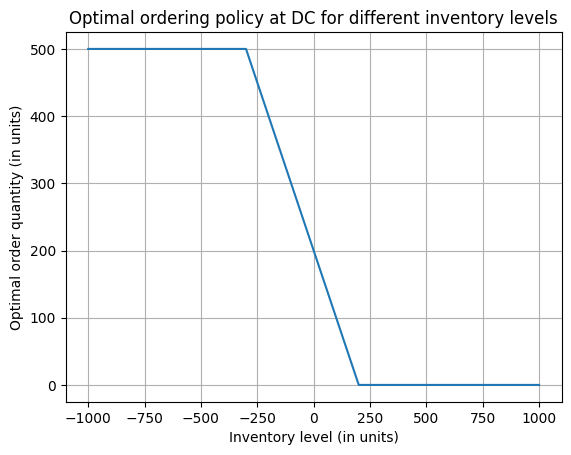

In [63]:
plt.plot(*zip(*sorted(optimal_policy.items())))
plt.title("Optimal ordering policy at DC for different inventory levels")
plt.xlabel("Inventory level (in units)")
plt.ylabel("Optimal order quantity (in units)")
plt.grid()
plt.show()

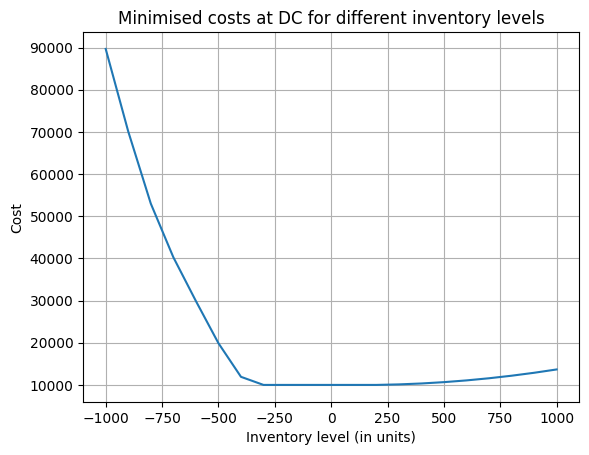

In [64]:
plt.plot(*zip(*sorted(cost_function.items())))
plt.title("Minimised costs at DC for different inventory levels")
plt.xlabel("Inventory level (in units)")
plt.ylabel("Cost")
plt.grid()
plt.show()

# Implementing Value Iteration to solve 2-echelon inventory optimisation MDP with lead times

In [65]:
def create_lead_P(demand_distribution):
    def prob_trans(s, a, sp):
        prob = 0
        if sp[1:] == (a,) + s[1:-1]: # check updated orders yet to arrive in new state
            demand = s[0] + s[-1] - sp[0]  # demand in time period
            prob = demand_distribution.get(demand, 0)
        
        return prob
    
    return prob_trans

def create_lead_R(demand_distribution, hold_cost, backlog_cost, order_cost):
    def cost_function(s, a):
        holding_cost = hold_cost*(sum(max(s[0] + s[-1] - dt, 0)*prob for dt, prob in demand_distribution.items()))
        backlogged_cost = backlog_cost*(sum(max(dt - s[0] - s[-1], 0)*prob for dt, prob in demand_distribution.items()))
        ordering_cost = order_cost*a

        return holding_cost + backlogged_cost + ordering_cost
    
    return cost_function


def lead_value_update_func(capacity):
    def bellman_eq_lead(s, S, A, P, R, gamma, Vk):
        values = dict((a, 0) for a in A)
        for a in values.keys():
            values[a] = R(s, a) + gamma*sum([P(s, a, sp)*Vk[sp] for sp in S])

        return values
    return bellman_eq_lead

In [126]:
capacity = 100
order_set = set(int(x) for x in np.arange(0, math.ceil(capacity/2)+1, 10))        # set of possible order quantities
inventory_set = set(int(x) for x in np.arange(-capacity, capacity + 1, 10))       # set of possible inventory levels
lead_time = 2                                                                     # lead time

S = set((inv, *arriving_order) for inv in inventory_set for arriving_order in itertools.product(order_set, repeat=lead_time))
A = order_set
demand_dist = {0: 0.2, 10: 0.6, 20: 0.2}
ch = 1
cb = 100
cs = 0
P = create_lead_P(demand_dist)
R = create_lead_R(demand_dist, ch, cb, cs)
V_init = dict([(s, 0) for s in S])    # initial probability of winning at all states is 0
gamma=0.999
bellman_eq_lead = lead_value_update_func(capacity)

results= value_iteration(S=S, A=A, P=P, R=R, gamma=0.9, max_iterations=100, 
                          bellman_eq=bellman_eq_lead, V_init=V_init, theta=1e-7)




Converged!


In [112]:
lead_optimal_policy = results["optimal_policy"]
lead_cost_function = results["value_function"]

In [113]:
lead_optimal_policy

{(-30, 10, 50): 20,
 (-20, 40, 50): 0,
 (80, 0, 10): 0,
 (-50, 40, 40): 20,
 (30, 10, 30): 0,
 (60, 20, 20): 0,
 (40, 50, 20): 0,
 (10, 30, 40): 0,
 (60, 50, 30): 0,
 (-70, 40, 0): 50,
 (-100, 0, 10): 50,
 (70, 0, 30): 0,
 (50, 40, 0): 0,
 (-90, 50, 40): 50,
 (90, 0, 40): 0,
 (10, 10, 0): 30,
 (-60, 20, 10): 50,
 (-70, 50, 50): 20,
 (100, 40, 30): 0,
 (-40, 20, 20): 50,
 (50, 50, 50): 0,
 (-80, 40, 20): 50,
 (-10, 20, 40): 0,
 (-60, 0, 40): 50,
 (-40, 0, 50): 40,
 (10, 20, 40): 0,
 (-60, 30, 50): 30,
 (80, 30, 10): 0,
 (-30, 40, 40): 0,
 (0, 10, 10): 30,
 (30, 40, 30): 0,
 (20, 10, 20): 0,
 (-100, 30, 10): 50,
 (90, 50, 0): 0,
 (-20, 0, 0): 50,
 (-80, 30, 20): 50,
 (70, 30, 30): 0,
 (-20, 30, 10): 30,
 (90, 30, 40): 0,
 (10, 40, 0): 0,
 (-60, 50, 10): 50,
 (100, 20, 20): 0,
 (-20, 10, 40): 20,
 (-40, 50, 10): 30,
 (-10, 50, 30): 0,
 (10, 50, 40): 0,
 (-10, 0, 20): 40,
 (40, 20, 10): 0,
 (10, 0, 30): 10,
 (0, 40, 10): 0,
 (40, 0, 50): 0,
 (20, 40, 20): 0,
 (-60, 40, 10): 50,
 (-90, 20, 

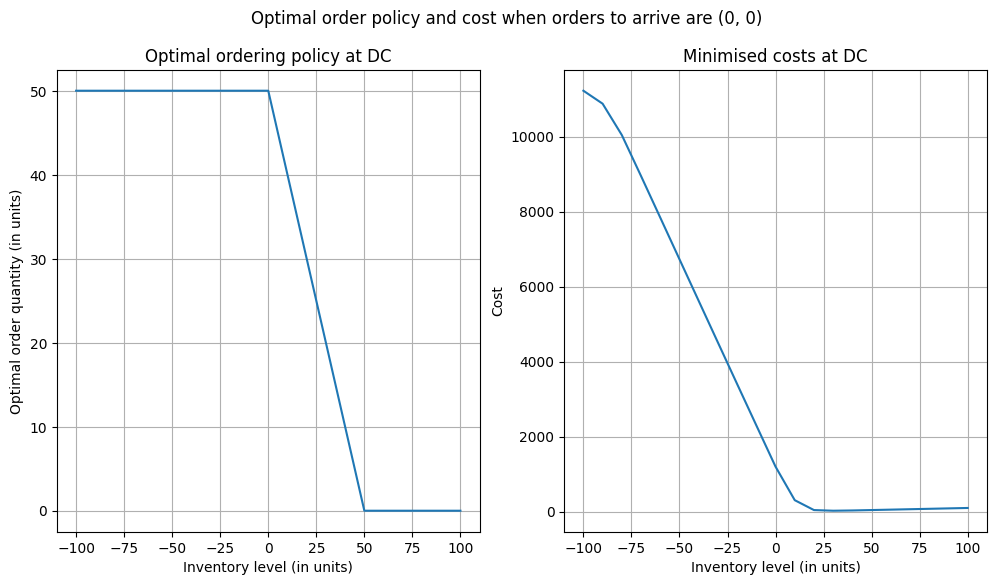

In [125]:
possible_lead_orders = set(itertools.product(order_set, repeat=lead_time))


def plot_per_lead_order(optimal_policy, cost_function, possible_lead_order):
    eligible_keys = [key for key in sorted(optimal_policy) if key[1:] == possible_lead_order]
    inv_levels = [key[0] for key in eligible_keys]
    opt_policy = [optimal_policy[key] for key in eligible_keys]
    opt_cost = [cost_function[key] for key in eligible_keys]
    fig, ax = plt.subplots(1,2, figsize=(12,6))
    ax[0].plot(inv_levels, opt_policy)
    ax[0].set(title = "Optimal ordering policy at DC", xlabel="Inventory level (in units)", ylabel="Optimal order quantity (in units)")
    ax[0].grid()
    ax[1].plot(inv_levels, opt_cost)
    ax[1].set(title = "Minimised costs at DC", xlabel="Inventory level (in units)", ylabel="Cost")
    ax[1].grid()
    plt.suptitle(f"Optimal order policy and cost when orders to arrive are {possible_lead_order}")
    plt.show()

plot_per_lead_order(lead_optimal_policy, lead_cost_function, (0,0))
    

In [128]:
# Check all states with same inventory positions have the same order quantity and maybe cost?

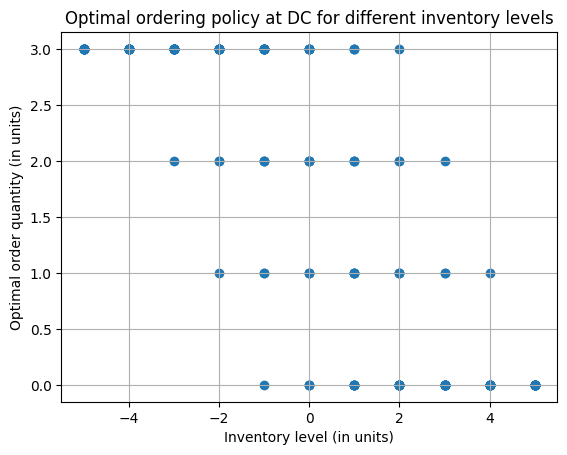

In [ ]:
sorted_policy = sorted(lead_optimal_policy.items(), key=lambda item: item[0][0])
inv_levels = [k[0] for k, v in sorted_policy]
opt_order_quantity = [v for k, v in sorted_policy]
plt.scatter(inv_levels, opt_order_quantity)
plt.title("Optimal ordering policy at DC for different inventory levels")
plt.xlabel("Inventory level (in units)")
plt.ylabel("Optimal order quantity (in units)")
plt.grid()
plt.show()

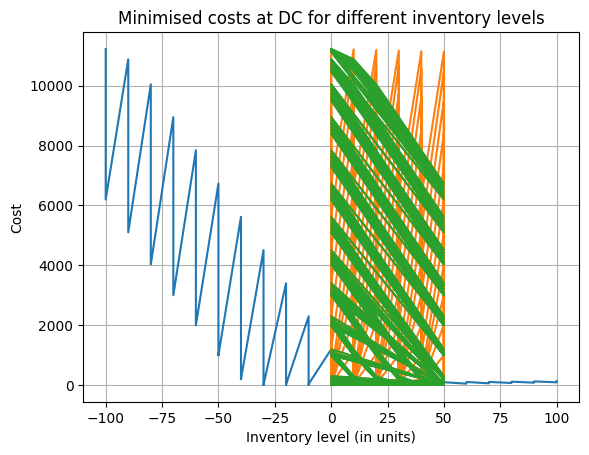

In [69]:
plt.plot(*zip(*sorted(lead_cost_function.items())))
plt.title("Minimised costs at DC for different inventory levels")
plt.xlabel("Inventory level (in units)")
plt.ylabel("Cost")
plt.grid()
plt.show()